# *Simulation of the pentose cycle in lactating rat mammary gland*

### By Haut MJ , London JW , Garfinkel D (1974)

__Abstract:__

A computer model representing the pentose cycle, the tricarboxylic acid cycle and glycolysis in slices of lactating rat mammary glands has been constructed. This model is based primarily on the studies, with radioactive chemicals, of Abraham & Chaikoff (1959) [although some of the discrepant data of Katz & Wals (1972) could be accommodated by changing one enzyme activity]. Data obtained by using [1-(14)C]-, [6-(14)C]- and [3,4-(14)C]-glucose were simulated, as well as data obtained by using unlabelled glucose (for which some new experimental data are presented). Much past work on the pentose cycle has been mainly concerned with the division of glucose flow between the pentose cycle and glycolysis, and has relied on the assumption that the system is in steady state (both labelled and unlabelled). This assumption may not apply to lactating rat mammary glands, since the model shows that the percentage flow through the shunt progressively decreased for the first 2h of a 3h experiment, and we were unable to construct a completely steady-state model. The model allows examination of many quantitative features of the system, especially the amount of material passing through key enzymes, some of which appear to be regulated by NADP(+) concentrations as proposed by McLean (1960). 


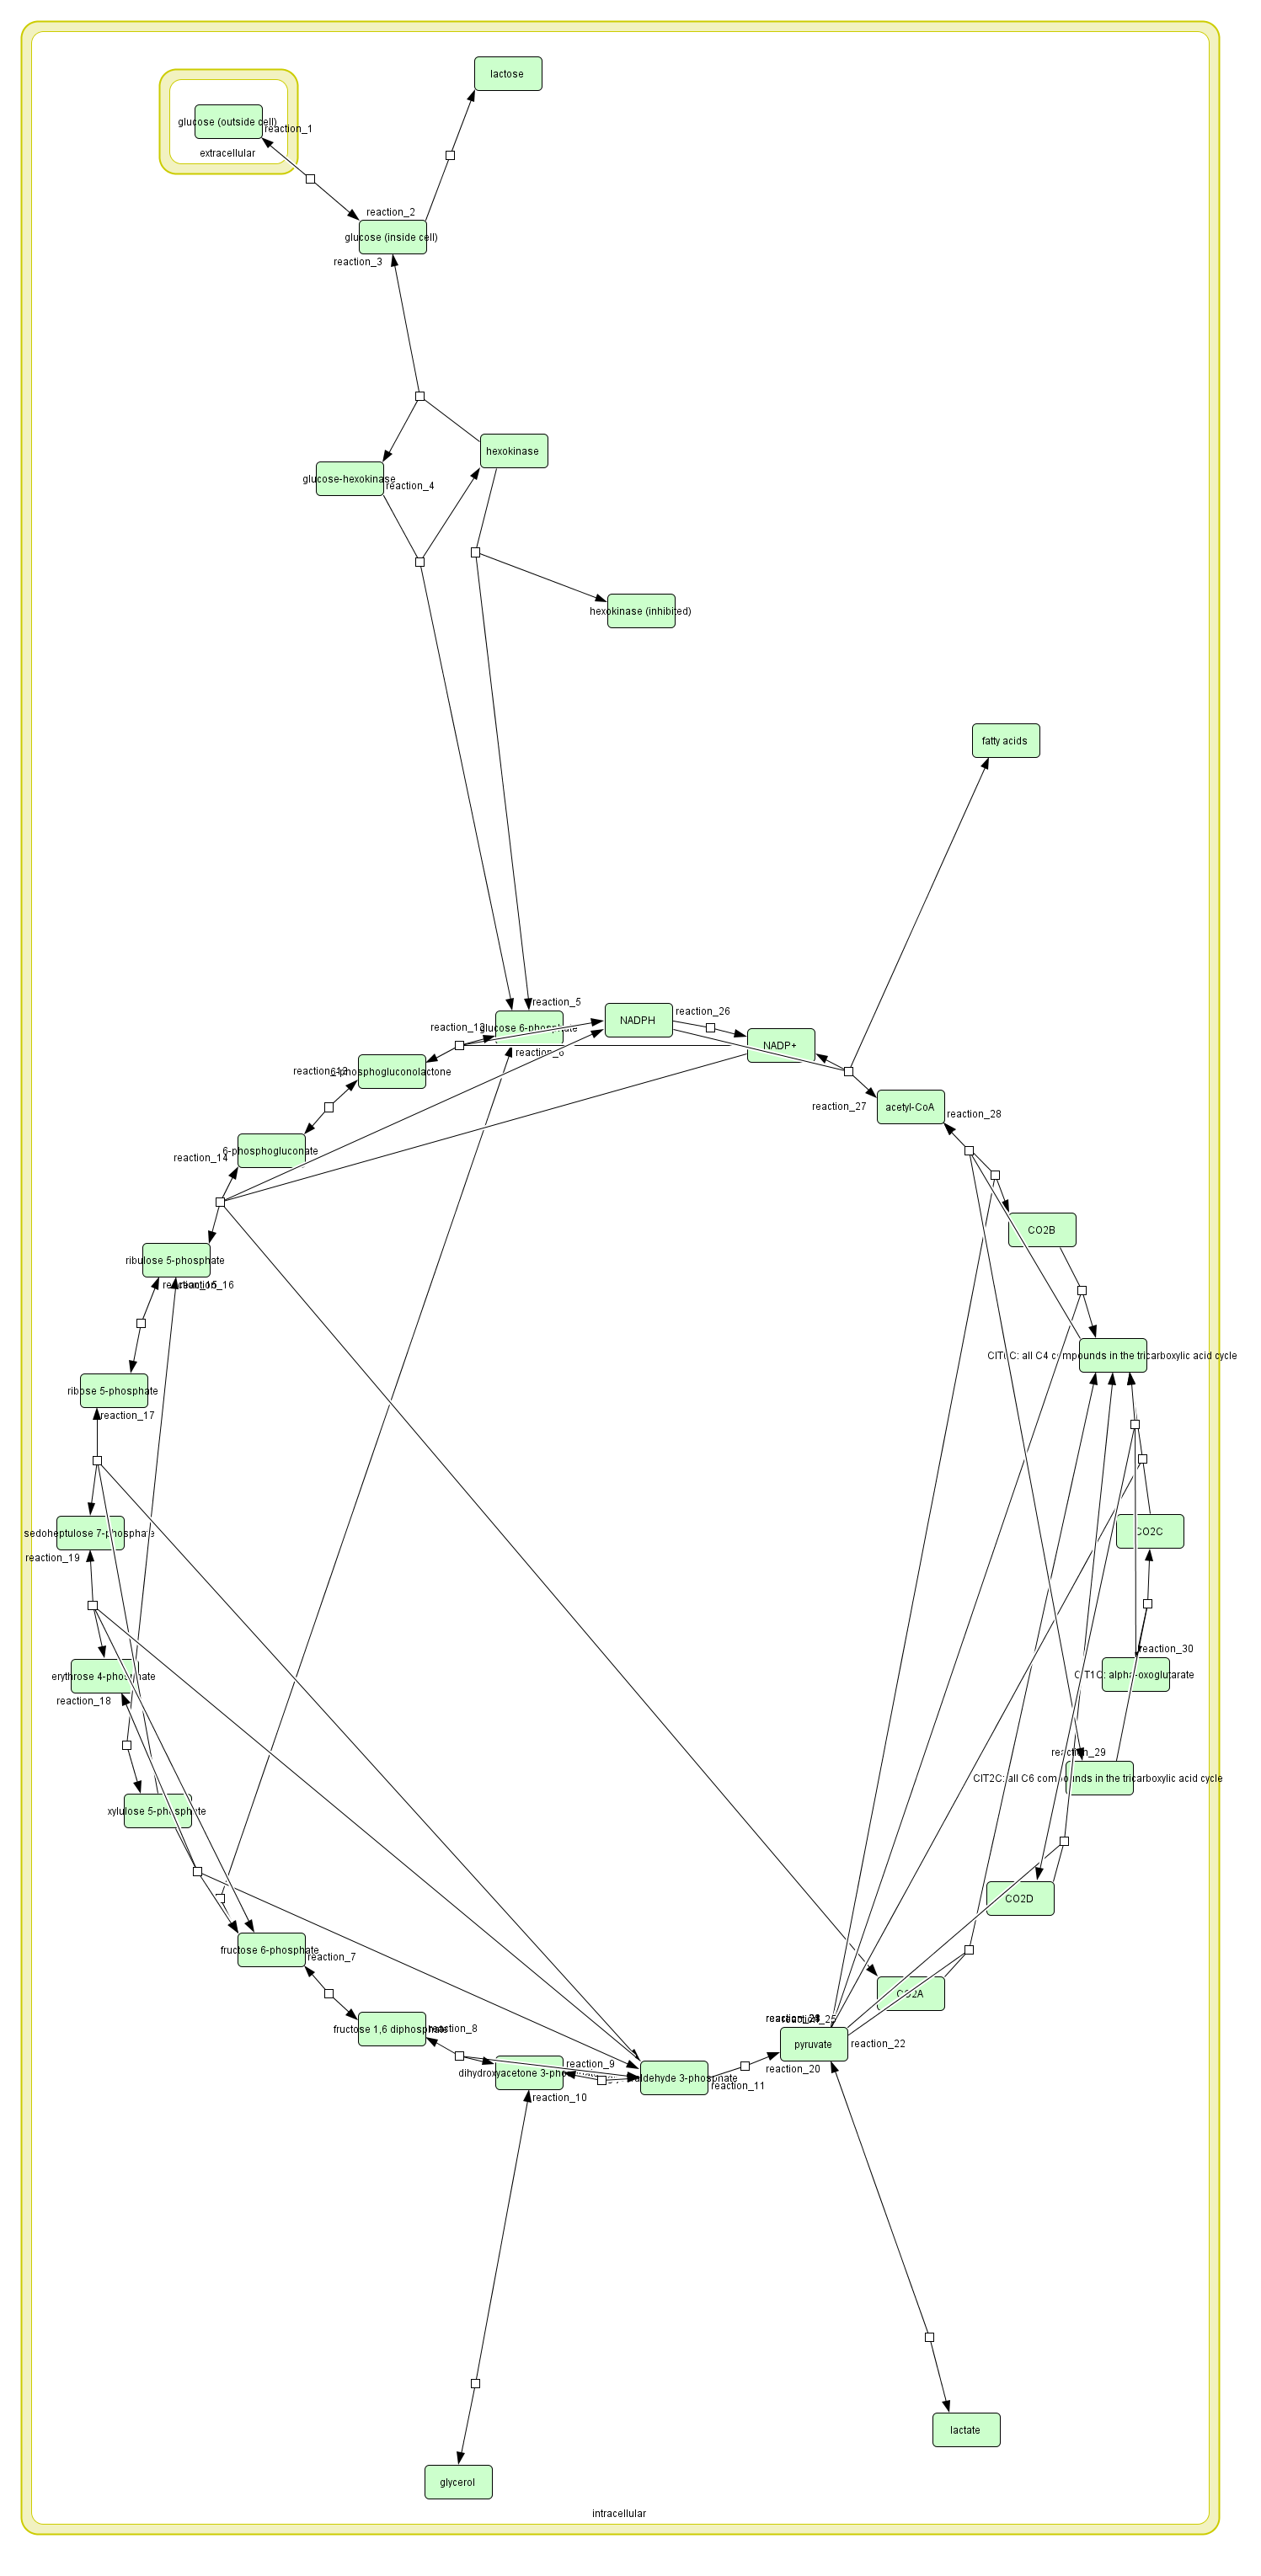

In [1]:
## Libraries:

# a) Bond graphs
import BondGraphTools as bgt

# b) Data extraction
from pyomexmeta import RDF, eUriType
import os
import sys

# c) General
import copy
import difflib
import numpy as np
import pandas as pd
import math
import operator as op
import ast
import re

# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams

# sbml
from libsbml import*
import simplesbml 

# Integration and fitting
from scipy.optimize import curve_fit, minimize, least_squares, newton_krylov, basinhopping
from scipy  import integrate
import scipy.stats as stats
from symfit import parameters, variables, log, Fit, GreaterThan, Model
from symfit.core.minimizers import BasinHopping
from gekko import GEKKO



The tests rely on tellurium to construct the models
Since tellurium is not installed the tests can't be run
If you want to run the tests, pip install tellurium first


In [2]:
# fluxes = pd.read_csv('fluxes.txt', delimiter=' ', index_col=False)
# species = pd.read_csv('species.txt', delimiter=' ', index_col=False)
# solutions = pd.merge(fluxes,species)
solutions = pd.read_csv('solutions.csv')

sboRef = pd.read_csv('SBO.csv')
sboID = sboRef['http://www.geneontology.org/formats/oboInOwl#id']
sboMeaning = sboRef['http://www.w3.org/2000/01/rdf-schema#label']
sboSynonyms = sboRef['Synonyms']

reader = SBMLReader()
document = reader.readSBML("MODEL1004070000_url.xml")
document.getNumErrors()

model_lib = document.getModel()
model_simple = simplesbml.loadSBMLFile("MODEL1004070000_url.xml")


print ('Num compartmetns = ', model_simple.getNumCompartments())
print ('Num parameters =', model_simple.getNumParameters())
print ('Num species =', model_simple.getNumSpecies())
print ('Num reactions = ', model_simple.getNumReactions())
print (model_simple.getListOfCompartmentIds())
print (model_simple.getListOfAllSpecies())
print ('List of reactions = ', model_simple.getListOfReactionIds())
print ('List of rules = ', model_simple.getListOfRuleIds())
print ('List of parameters = ', model_simple.getListOfParameterIds())


Num compartmetns =  2
Num parameters = 0
Num species = 32
Num reactions =  30
['intracellular', 'extracellular']
['glucose_inside_cell', 'glucose_outside_cell', 'lactose', 'glucose_hexokinase', 'hexokinase', 'glucose_6_phosphate', 'hexokinase_inhibited', 'fructose_6_phosphate', 'fructose_16_diphosphate', 'dihydroxyacetone_3_phosphate', 'glyceraldehyde_3_phosphate', 'glycerol', 'pyruvate', '_6_phosphogluconolactone', 'NADP', 'NADPH', '_6_phosphogluconate', 'CO2A', 'ribulose_5_phosphate', 'ribose_5_phosphate', 'xylulose_5_phosphate', 'sedoheptulose_7_phosphate', 'erythrose_4_phosphate', 'lactate', 'acetyl_CoA', 'CO2B', 'CIT0C', 'CO2C', 'CO2D', 'fatty_acids', 'CIT2C', 'CIT1C']
List of reactions =  ['reaction_1', 'reaction_2', 'reaction_3', 'reaction_4', 'reaction_5', 'reaction_6', 'reaction_7', 'reaction_8', 'reaction_9', 'reaction_10', 'reaction_11', 'reaction_12', 'reaction_13', 'reaction_14', 'reaction_15', 'reaction_16', 'reaction_17', 'reaction_18', 'reaction_19', 'reaction_20', 'rea

In [3]:
# Categorizing the reactions
reaction_reactants={}; reaction_products={}; reaction_modifiers={}; Synthesis=[]; Dtype=[]

for reaction in model_simple.getListOfReactionIds():
    reaction_reactants[reaction]=[]
    reaction_products[reaction]=[]
    reaction_modifiers[reaction]=[]
    
    reactNum=model_simple.getNumReactants(reaction)
    prodNum=model_simple.getNumProducts(reaction)
    modifierNum=model_simple.getNumModifiers(reaction)
    
    if reactNum is 0:
        Synthesis.append(reaction)
    if prodNum is 0:
        Dtype.append(reaction)
        
    if modifierNum is not 0:             
        for iii in range(modifierNum):
            reaction_modifiers[reaction].append((1,model_simple.getListOfModifiers(reaction)[0]))

    for i in range(reactNum):
        reaction_reactants[reaction].append((model_simple.getReactantStoichiometry(reaction, i),model_simple.getReactant(reaction, i)))


    for ii in range(prodNum):
        reaction_products[reaction].append((model_simple.getProductStoichiometry(reaction, ii),model_simple.getProduct(reaction, ii)))


            
            
reversibles=[]; irreversibles=[]; 

for (reaction,r) in zip(model_simple.getListOfReactionIds(),range(len(model_lib.getListOfReactions()))):
#     if model_simple.getNumModifiers(reaction) is not 0:  
#         irreversibles.append(reaction) 
        
#     else:
    
    if model_lib.getListOfReactions()[r].getReversible() is True:
        reversibles.append(reaction)
    else:
        if reaction not in [synth for synth in Synthesis] and reaction not in [d for d in Dtype]:
            irreversibles.append(reaction)  

 
        
speciesId=[]
for species in model_simple.getListOfAllSpecies():
    for i,reacs in enumerate(reaction_reactants.values()):
        if species in [reac[1] for reac in reacs] and species not in [d for d in speciesId]:
            speciesId.append(species)

    for i,prods in enumerate(reaction_products.values()):
        if species in [prod[1] for prod in prods] and species not in [d for d in speciesId]:
            speciesId.append(species)

In [4]:
reversibles

['reaction_1',
 'reaction_3',
 'reaction_5',
 'reaction_6',
 'reaction_7',
 'reaction_8',
 'reaction_9',
 'reaction_10',
 'reaction_12',
 'reaction_13',
 'reaction_14',
 'reaction_15',
 'reaction_16',
 'reaction_17',
 'reaction_18',
 'reaction_19',
 'reaction_20',
 'reaction_27',
 'reaction_28']

In [5]:
irreversibles

['reaction_2',
 'reaction_4',
 'reaction_11',
 'reaction_21',
 'reaction_22',
 'reaction_23',
 'reaction_24',
 'reaction_25',
 'reaction_26',
 'reaction_29',
 'reaction_30']

In [6]:
reaction_reactants

{'reaction_1': [(1.0, 'glucose_outside_cell')],
 'reaction_2': [(1.0, 'glucose_inside_cell')],
 'reaction_3': [(1.0, 'glucose_inside_cell'), (1.0, 'hexokinase')],
 'reaction_4': [(1.0, 'glucose_hexokinase')],
 'reaction_5': [(1.0, 'glucose_6_phosphate'), (1.0, 'hexokinase')],
 'reaction_6': [(1.0, 'glucose_6_phosphate')],
 'reaction_7': [(1.0, 'fructose_6_phosphate')],
 'reaction_8': [(1.0, 'fructose_16_diphosphate')],
 'reaction_9': [(1.0, 'dihydroxyacetone_3_phosphate')],
 'reaction_10': [(1.0, 'dihydroxyacetone_3_phosphate')],
 'reaction_11': [(1.0, 'glyceraldehyde_3_phosphate')],
 'reaction_12': [(1.0, 'glucose_6_phosphate'), (1.0, 'NADP')],
 'reaction_13': [(1.0, '_6_phosphogluconolactone')],
 'reaction_14': [(1.0, '_6_phosphogluconate'), (1.0, 'NADP')],
 'reaction_15': [(1.0, 'ribulose_5_phosphate')],
 'reaction_16': [(1.0, 'ribulose_5_phosphate')],
 'reaction_17': [(1.0, 'ribose_5_phosphate'), (1.0, 'xylulose_5_phosphate')],
 'reaction_18': [(1.0, 'erythrose_4_phosphate'),
  (1.

In [7]:
reaction_products

{'reaction_1': [(1.0, 'glucose_inside_cell')],
 'reaction_2': [(1.0, 'lactose')],
 'reaction_3': [(1.0, 'glucose_hexokinase')],
 'reaction_4': [(1.0, 'glucose_6_phosphate'), (1.0, 'hexokinase')],
 'reaction_5': [(1.0, 'hexokinase_inhibited')],
 'reaction_6': [(1.0, 'fructose_6_phosphate')],
 'reaction_7': [(1.0, 'fructose_16_diphosphate')],
 'reaction_8': [(1.0, 'glyceraldehyde_3_phosphate'),
  (1.0, 'dihydroxyacetone_3_phosphate')],
 'reaction_9': [(1.0, 'glyceraldehyde_3_phosphate')],
 'reaction_10': [(1.0, 'glycerol')],
 'reaction_11': [(1.0, 'pyruvate')],
 'reaction_12': [(1.0, '_6_phosphogluconolactone'), (1.0, 'NADPH')],
 'reaction_13': [(1.0, '_6_phosphogluconate')],
 'reaction_14': [(1.0, 'ribulose_5_phosphate'), (1.0, 'CO2A'), (1.0, 'NADPH')],
 'reaction_15': [(1.0, 'ribose_5_phosphate')],
 'reaction_16': [(1.0, 'xylulose_5_phosphate')],
 'reaction_17': [(1.0, 'sedoheptulose_7_phosphate'),
  (1.0, 'glyceraldehyde_3_phosphate')],
 'reaction_18': [(1.0, 'fructose_6_phosphate'),


In [8]:
# Reversible reactions ==> species constants approximation

Kp_to_Kr = []

for reaction in reversibles:
    
    phi_Xr_1 = 1
    phi_Xp_1 = 1
    phi_Xr_e = 1
    phi_Xp_e = 1
    
    sigma = solutions[reaction][len(solutions[reaction])-1] / solutions[reaction][1]
    
    for stoichiometry,reactant in reaction_reactants[reaction]:
        
        phi_Xr_1 = phi_Xr_1 * solutions[reactant][1]
        phi_Xr_e = phi_Xr_e * solutions[reactant][len(solutions[reactant])-1]
        
#         if reactant not in rowM:
#             rowM.append(reactant)

    for stoichiometry,product in reaction_products[reaction]:        
        phi_Xp_1 = phi_Xp_1 * solutions[product][1]
        phi_Xp_e = phi_Xp_e * solutions[product][len(solutions[product])-1]
        
#         if product not in rowM:
#             rowM.append(product)

    Kp_to_Kr.append((sigma*phi_Xr_1 - phi_Xr_e)/(sigma*phi_Xp_1 - phi_Xp_e))

trueValues = Kp_to_Kr


rowM=[]
for s in speciesId:
     rowM.append(s)
        
# M initial (regarding the steady-state ratios obtained in the previous stage)

M = np.zeros([len(trueValues),len(rowM)]) 

                
for reaction,i in zip(reversibles,range(len(reversibles))):
    for stoichiometry,reactant in reaction_reactants[reaction]:
        for r in range(len(rowM)):     
            if len(rowM[r])==len(reactant) and set(rowM[r]) == set(reactant):  
                M[i][r] = -stoichiometry


    for stoichiometry,product in reaction_products[reaction]:
        for r in range(len(rowM)):     
            if len(rowM[r])==len(product) and set(rowM[r]) == set(product):                    
                M[i][r] = stoichiometry


logTrueValues = [];

for k in trueValues:
    logTrueValues.append(math.log(k))

logTrueValues = np.array(logTrueValues)


Mpinv = np.linalg.pinv(np.array(M))
logU = Mpinv.dot(logTrueValues)

thermodynamics = [math.exp(i) for i in list(logU)]
for i in range(len(thermodynamics)):
    print(rowM[i],' ==> ',thermodynamics[i])

diff = logTrueValues-M.dot(logU)
np.exp(diff)




glucose_inside_cell  ==>  5.719247304255948
glucose_outside_cell  ==>  0.32275661987900434
lactose  ==>  1.000000000000001
glucose_hexokinase  ==>  0.5417338401672368
hexokinase  ==>  0.9472117740822731
glucose_6_phosphate  ==>  34.296946735957356
hexokinase_inhibited  ==>  1.948798546093061
fructose_6_phosphate  ==>  0.9526929648881807
fructose_16_diphosphate  ==>  0.11432315578493031
dihydroxyacetone_3_phosphate  ==>  0.04477936868024963
glyceraldehyde_3_phosphate  ==>  0.11284400907423583
glycerol  ==>  0.009950970817833268
pyruvate  ==>  7.7459666924148465
_6_phosphogluconolactone  ==>  4.837776646013714
NADP  ==>  1.5443439347865873
NADPH  ==>  0.6475241540921334
_6_phosphogluconate  ==>  0.4837776646013719
CO2A  ==>  0.03221222133694876
ribulose_5_phosphate  ==>  2.0824987326820503
ribose_5_phosphate  ==>  0.6747295893889891
xylulose_5_phosphate  ==>  1.4087491426966863
sedoheptulose_7_phosphate  ==>  7.019459417191395
erythrose_4_phosphate  ==>  0.7908788594518746
lactate  ==>  

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


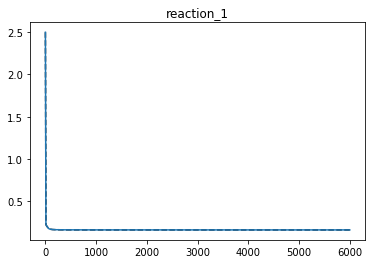

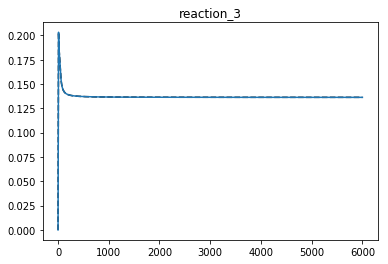

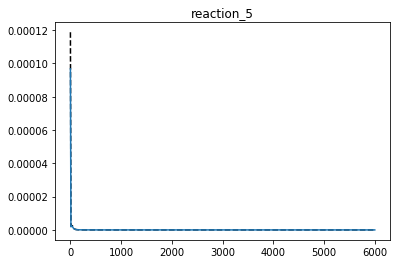

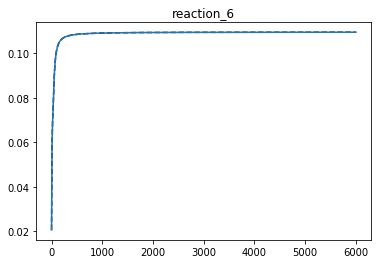

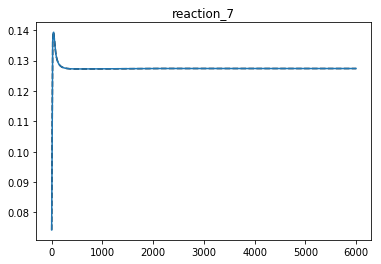

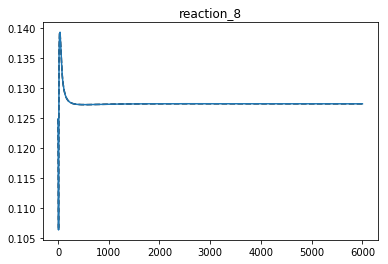

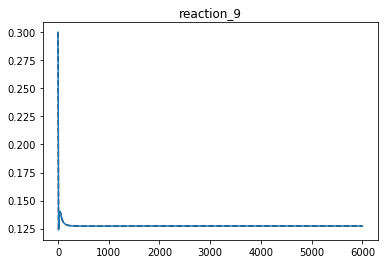

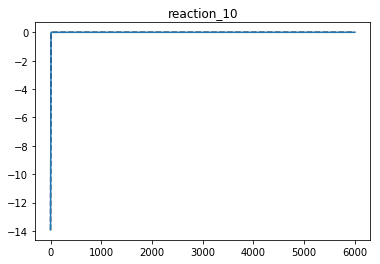

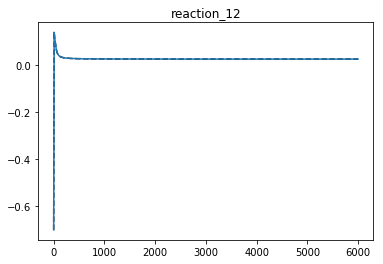

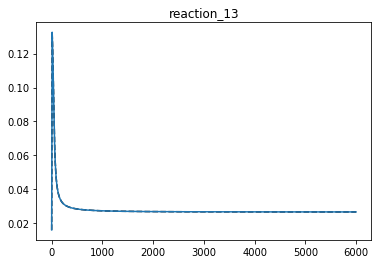

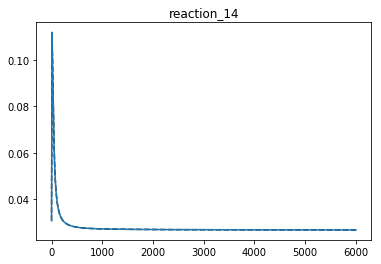

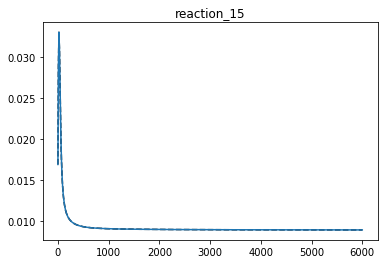

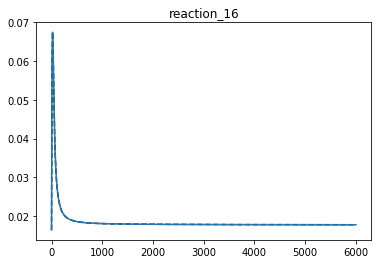

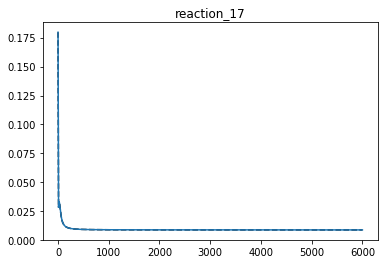

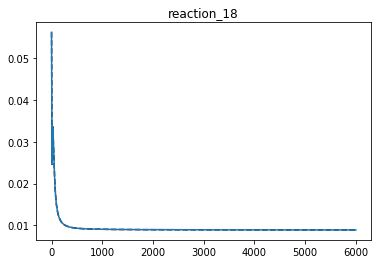

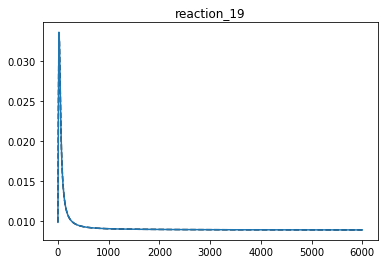

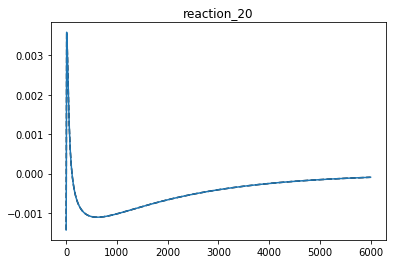

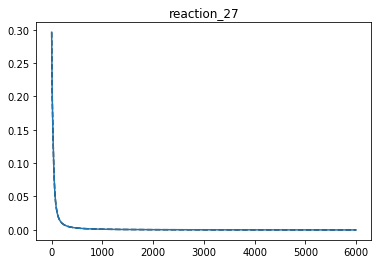

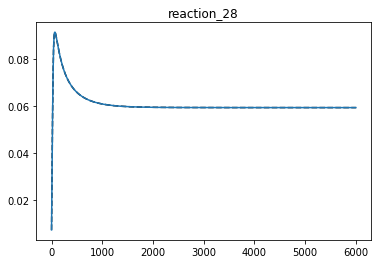

In [9]:
reactionRates = {}
for reaction in  reversibles:
    
    reactantsSpecies=[]
    productsSpecies=[]
    modifierSpecies=[]
    
    K_reactants = 1
    K_products = 1
    K_modifier = 1
    
    solve=tuple()
    
    for stoichiometry,reactant in reaction_reactants[reaction]:
        reactantsSpecies.append(reactant)        
        solve=solve+(pow(solutions[reactant],stoichiometry),)
        
        for i in range(len(rowM)):
            if len(rowM[i]) == len(reactant) and set(rowM[i]) == set(reactant):
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)   

    for stoichiometry,product in reaction_products[reaction]:
        productsSpecies.append(product)        
        solve=solve+(pow(solutions[product],stoichiometry),)
        
        for i in range(len(rowM)):
            if len(rowM[i]) == len(product) and set(rowM[i]) == set(product):
                K_products = K_products * pow(thermodynamics[i],stoichiometry)
            

            
      
    def func(X, r):


        reactants = np.ones((len(solutions['Time'])))
        products= np.ones((len(solutions['Time'])))
#         modifiers = np.ones((len(solutions['time'])))


        for x in range(0,len(reactantsSpecies)):
            reactants = reactants * X[x]            

        for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
            products = products * X[x]
            

        v = r*(K_reactants*reactants- K_products*products)


        return v


    bounds=[[0],[np.inf]]
    popt, pcov = curve_fit(func,solve,solutions[reaction], maxfev=300000, bounds=bounds)
    if popt[0]==1: 
        popt, pcov = curve_fit(func,solve,solutions[reaction], maxfev=300000, method='lm')

    reactionRates[reaction]=popt[0]

    
    
    reactants = np.ones((len(solutions['Time'])))
    products = np.ones((len(solutions['Time'])))
    for s,reac in reaction_reactants[reaction]:
        reactants=reactants*pow(solutions[reac],s)
    for s,pro in reaction_products[reaction]:
        products=products*pow(solutions[pro],s)
        
    plt.figure()
    plt.plot(solutions['Time'],popt[0]*(K_reactants*reactants-K_products*products),'k--')
    plt.plot(solutions['Time'],solutions[reaction])
    plt.title(reaction)

In [10]:
speciesXconstant = {}
for reaction in irreversibles:
    RSS = 1; PSS=1;
    for stoichiometry,reactant in reaction_reactants[reaction]:

        diff = solutions[reactant].diff() 
        diff.fillna(method='bfill', inplace=True)
        if diff.all() == 0 and solutions[reactant].all() == 0:
            RSS = RSS * 1
        else:

            length = solutions[reactant].size
            RSS = RSS * pow(solutions[reactant][length-1],stoichiometry)

    for stoichiometry,product in reaction_products[reaction]:

        diff = solutions[product].diff() 
        diff.fillna(method='bfill', inplace=True)
        if diff.all() == 0 and solutions[reactant].all() == 0:
            PSS = PSS * 1
        else:
            length = solutions[product].size
            PSS = PSS * pow(solutions[product][length-1],stoichiometry)

    speciesXconstant[reaction]=1e-3*RSS/PSS
speciesXconstant

{'reaction_2': 1.852811607763427e-05,
 'reaction_4': 0.0031464106171078185,
 'reaction_11': 0.0005949213403540895,
 'reaction_21': 0.04381634103514594,
 'reaction_22': 4.422680100256199e-07,
 'reaction_23': 9.770717822260043e-07,
 'reaction_24': 9.823744334037436e-07,
 'reaction_25': 9.823745037660526e-07,
 'reaction_26': 0.015547355781925907,
 'reaction_29': 4.973010806722172e-05,
 'reaction_30': 6.514855145862591e-09}

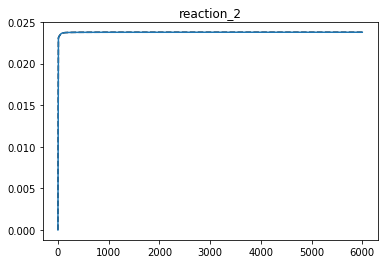

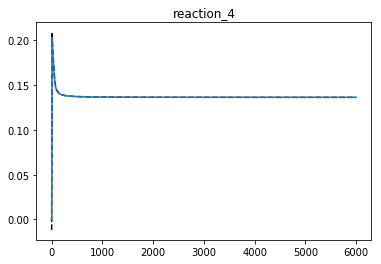

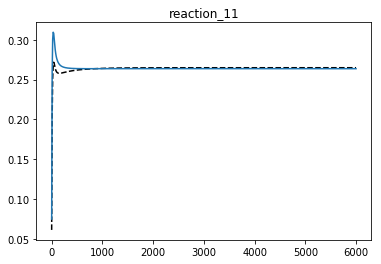

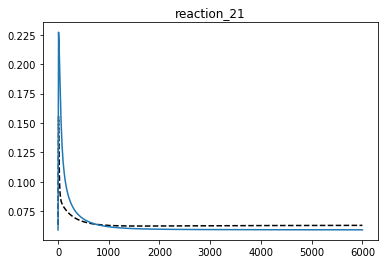

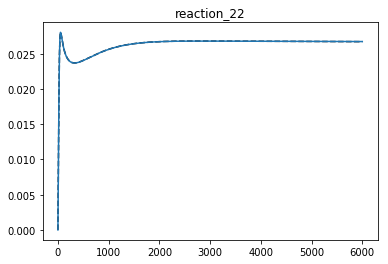

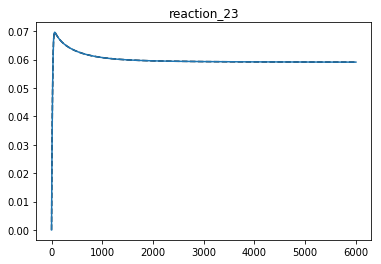

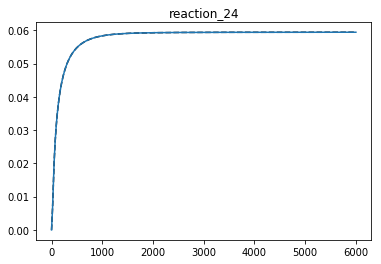

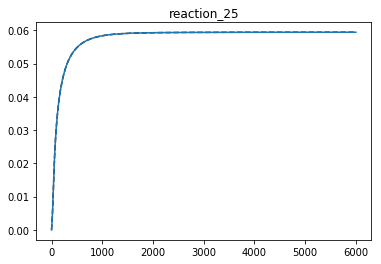

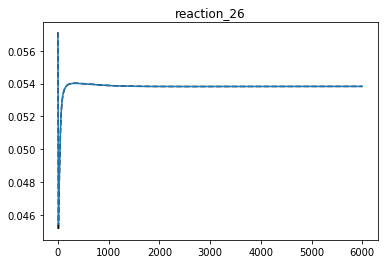

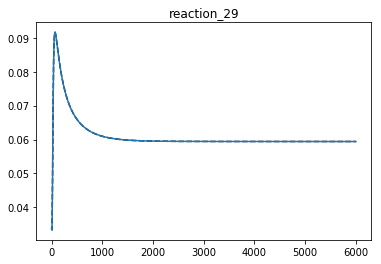

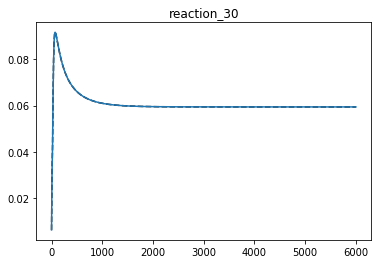

In [11]:
for reaction in  irreversibles:
    
    reactantsSpecies=[]
    productsSpecies=[]
    modifierSpecies=[]
    
    K_reactants = 1
    K_products = 1
    K_modifier = 1
    
    solve=tuple()
    
    for stoichiometry,reactant in reaction_reactants[reaction]:
        reactantsSpecies.append(reactant)        
        solve=solve+(pow(solutions[reactant],stoichiometry),)
        
        for i in range(len(rowM)):
            if len(rowM[i]) == len(reactant) and set(rowM[i]) == set(reactant):
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)   

    for stoichiometry,product in reaction_products[reaction]:
        productsSpecies.append(product)        
        solve=solve+(pow(solutions[product],stoichiometry),)
        
        for i in range(len(rowM)):
            if len(rowM[i]) == len(product) and set(rowM[i]) == set(product):
                K_products = K_products * pow(thermodynamics[i],stoichiometry)
            
    K_x = speciesXconstant[reaction]
            
      
    def func(X, r):


        reactants = np.ones((len(solutions['Time'])))
        products= np.ones((len(solutions['Time'])))


        for x in range(0,len(reactantsSpecies)):
            reactants = reactants * X[x]            

        for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
            products = products * X[x]
            

        v = r*(K_reactants*reactants- K_products*products*K_x)


        return v


    bounds=[[0],[np.inf]]
    popt, pcov = curve_fit(func,solve,solutions[reaction], maxfev=300000, bounds=bounds)
    if popt[0]==1: 
        popt, pcov = curve_fit(func,solve,solutions[reaction], maxfev=300000, method='lm')

    reactionRates[reaction]=popt[0]

    
    
    reactants = np.ones((len(solutions['Time'])))
    products = np.ones((len(solutions['Time'])))
    for s,reac in reaction_reactants[reaction]:
        reactants=reactants*solutions[reac]
    for s,pro in reaction_products[reaction]:
        products=products*solutions[pro]
        
    plt.figure()
    plt.plot(solutions['Time'],popt[0]*(K_reactants*reactants-K_products*products*K_x),'k--')
    plt.plot(solutions['Time'],solutions[reaction])
    plt.title(reaction)

In [12]:
# BG model 
BGmodel=bgt.new(name='BGmodel')
idealGassConstant=8.314
T= 310

BGspecies=[]; BGzeroJunc=[]; BGreactions=[]; oneJunc_reac=[]; oneJunc_prod=[]; TF=[];

    
for reaction in reversibles + irreversibles:
        
    BGreactions.append(bgt.new("Re", name=reaction, library="BioChem", value={'R':idealGassConstant, 'T':T}))

    oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction)) 
    oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction))

    
    for stoichiometry,reactant in reaction_reactants[reaction]:
        if stoichiometry != 1:
            TF.append(bgt.new('TF', name='oneReac '+reaction+' '+reactant, value=stoichiometry))
            
    for stoichiometry,product in reaction_products[reaction]:
        if stoichiometry != 1:
            TF.append(bgt.new('TF', name='oneProd '+reaction+' '+product, value=1/stoichiometry))
            
    if reaction in irreversibles:
        BGspecies.append(bgt.new("Ce_S", name=reaction+' X', library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=reaction+' X'))  
            
#     for forwardStoichiometry,backwardStoichiometry in refinedStoichiometries[reaction]:
#         TF.append(bgt.new('TF', name='oneReac '+reaction, value=forwardStoichiometry))
#         TF.append(bgt.new('TF', name='oneProd '+reaction, value=1/backwardStoichiometry))
        

    
for species in speciesId:
    diff = solutions[species].diff() 
    diff.fillna(method='bfill', inplace=True)
    if diff.all() != 0:
        BGspecies.append(bgt.new("Ce", name=species, library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=species)) 
    elif diff.all() == 0:
        BGspecies.append(bgt.new("Ce_S", name=species, library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=species)) 
    
    
for comp in TF:
    bgt.add(BGmodel,comp)
    
for comp1,comp2 in zip(BGspecies,BGzeroJunc):
    bgt.add(BGmodel,comp1,comp2)
    
for comp1,comp2,comp3 in zip(BGreactions,oneJunc_reac,oneJunc_prod):
    bgt.add(BGmodel,comp1,comp2,comp3)

In [13]:
# connections
connections = []

for z in BGzeroJunc:
    for s in BGspecies:
        if (z.name) == (s.name):
            connections.append((z,s))
    

for r in BGreactions:
    for oneR,oneP in zip(oneJunc_reac,oneJunc_prod):    
        if len('oneReac '+r.name) == len(oneR.name) and ('oneReac '+r.name) == (oneR.name):
            connections.append((oneR,r))
            
            
        if len('oneProd '+r.name) == len(oneP.name) and ('oneProd '+r.name) == (oneP.name):
            connections.append((r,oneP))

                
                
for reaction in reversibles + irreversibles:
    for oneR in oneJunc_reac:
        for xR in oneR.name.split(sep=" "):
            if (reaction) == (xR):

                for z in BGzeroJunc:
                    for stoichiometry,reactant in reaction_reactants[reaction]:
                        if  z.name == reactant:                            
                            connections.append((z,oneR))

                                    
    for oneP in oneJunc_prod:
        for xP in oneP.name.split(sep=" "):
            if (reaction) == (xP):

                for z in BGzeroJunc:
                    for stoichiometry,product in reaction_products[reaction]:
                        if z.name == product:
                            connections.append((oneP,z))
                            
                    if reaction in irreversibles:
                        if  z.name == reaction+' X':
                            connections.append((oneP,z))
    
      
        
for tail,head in connections:
    bgt.connect(tail,head)

In [14]:
# Setting the values in BGs
           
for BGreaction in BGreactions:
    if BGreaction.name in [key for key in reactionRates]:
            bgt.set_param(BGreaction,'r',reactionRates[BGreaction.name])
        

for bg in BGspecies:                   
    for i in range(len(rowM)):
        if bg.name == rowM[i]:
            bgt.set_param(bg,'k',thermodynamics[i])

            
for reaction in irreversibles:
    for bg in BGspecies: 
        if bg.name == reaction+' X':
            bgt.set_param(bg,'k',speciesXconstant[reaction])

In [15]:
# check if all the components have gotton the correct values
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'C':
        print(BGmodel.components[i],BGmodel.components[i]._params['k'])
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'R':
        print(BGmodel.components[i],BGmodel.components[i]._params['r'])
for i in range(len(BGmodel.components)):
    if BGmodel.components[i].metamodel == 'TF':
        print(BGmodel.components[i],BGmodel.components[i]._params['r'])
        

C: reaction_2 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 1.852811607763427e-05}
C: reaction_4 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.0031464106171078185}
C: reaction_11 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.0005949213403540895}
C: reaction_21 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.04381634103514594}
C: reaction_22 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 4.422680100256199e-07}
C: reaction_23 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 9.770717822260043e-07}
C: reaction_24 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 9.823744334037436e-07}
C: reaction_25 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 9.823745037660526e-07}
C: reaction_26 X {'description': 'Biochemical Constant; exp(mu_0/RT)/V', 'value': 0.015547355781925907}
C: reaction_29 X {'description': 'Biochemical Constant; exp(

In [16]:
BGmodel.state_vars

{'x_0': (C: reaction_2 X, 'q_0'),
 'x_1': (C: reaction_4 X, 'q_0'),
 'x_2': (C: reaction_11 X, 'q_0'),
 'x_3': (C: reaction_21 X, 'q_0'),
 'x_4': (C: reaction_22 X, 'q_0'),
 'x_5': (C: reaction_23 X, 'q_0'),
 'x_6': (C: reaction_24 X, 'q_0'),
 'x_7': (C: reaction_25 X, 'q_0'),
 'x_8': (C: reaction_26 X, 'q_0'),
 'x_9': (C: reaction_29 X, 'q_0'),
 'x_10': (C: reaction_30 X, 'q_0'),
 'x_11': (C: glucose_inside_cell, 'q_0'),
 'x_12': (C: glucose_outside_cell, 'q_0'),
 'x_13': (C: lactose, 'q_0'),
 'x_14': (C: glucose_hexokinase, 'q_0'),
 'x_15': (C: hexokinase, 'q_0'),
 'x_16': (C: glucose_6_phosphate, 'q_0'),
 'x_17': (C: hexokinase_inhibited, 'q_0'),
 'x_18': (C: fructose_6_phosphate, 'q_0'),
 'x_19': (C: fructose_16_diphosphate, 'q_0'),
 'x_20': (C: dihydroxyacetone_3_phosphate, 'q_0'),
 'x_21': (C: glyceraldehyde_3_phosphate, 'q_0'),
 'x_22': (C: glycerol, 'q_0'),
 'x_23': (C: pyruvate, 'q_0'),
 'x_24': (C: _6_phosphogluconolactone, 'q_0'),
 'x_25': (C: NADP, 'q_0'),
 'x_26': (C: NADP

In [17]:
x_0 = {}
for stateVar in BGmodel.state_vars:                   
    for reaction in irreversibles:
        if BGmodel.state_vars[stateVar][0].name == reaction+' X':
            x_0[stateVar] =  1
            
for stateVar in BGmodel.state_vars:                   
    for bg in BGspecies:
        if bg.name in solutions:
            if len(BGmodel.state_vars[stateVar][0].name) == len(bg.name) and set(BGmodel.state_vars[stateVar][0].name) == set(bg.name):
                x_0[stateVar] =  solutions[bg.name][0]

    
x_0      

{'x_0': 1,
 'x_1': 1,
 'x_2': 1,
 'x_3': 1,
 'x_4': 1,
 'x_5': 1,
 'x_6': 1,
 'x_7': 1,
 'x_8': 1,
 'x_9': 1,
 'x_10': 1,
 'x_11': 1e-09,
 'x_12': 50.0,
 'x_13': 1e-09,
 'x_14': 1e-09,
 'x_15': 0.001,
 'x_16': 0.058,
 'x_17': 1e-09,
 'x_18': 0.0312,
 'x_19': 0.0125,
 'x_20': 0.0352,
 'x_21': 0.01,
 'x_22': 0.437,
 'x_23': 0.059,
 'x_24': 0.094,
 'x_25': 0.019,
 'x_26': 3.8,
 'x_27': 0.094,
 'x_28': 1e-09,
 'x_29': 0.5,
 'x_30': 0.5,
 'x_31': 0.5,
 'x_32': 0.06,
 'x_33': 0.004,
 'x_34': 6.4,
 'x_35': 0.1,
 'x_36': 1e-09,
 'x_37': 0.307,
 'x_38': 1e-09,
 'x_39': 1e-09,
 'x_40': 6.67,
 'x_41': 0.09,
 'x_42': 0.017}

In [18]:
BGmodel.control_vars

{}

In [19]:
t_span = [0,solutions['Time'][len(solutions['Time'])-1]]
t, x = bgt.simulate(BGmodel, timespan=t_span, control_vars={}, x0=x_0, dt=solutions['Time'][1]-solutions['Time'][0])

In [21]:
# Saving the simulations as a csv file
xDict = {}
for i in range(np.size(x,1)):
    xDict[i] = x[:,i]

bgData = pd.DataFrame(xDict)
bgData.to_csv("/Users/nsha457/Documents/Jupyter_files/SBML_AnnotMerge/TCA cycle/MODEL1004070000/Comparison/bgData.csv",\
         sep=',', index=False) 

c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot 

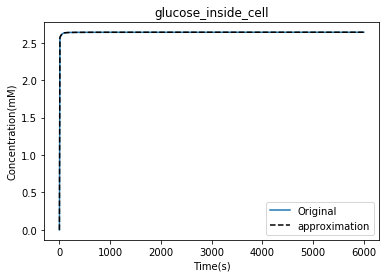

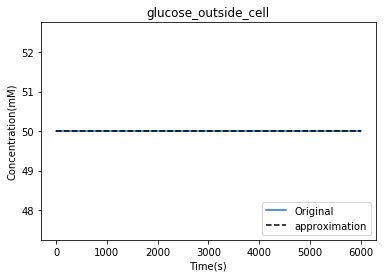

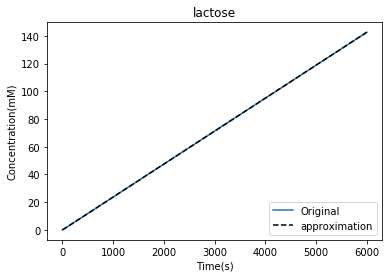

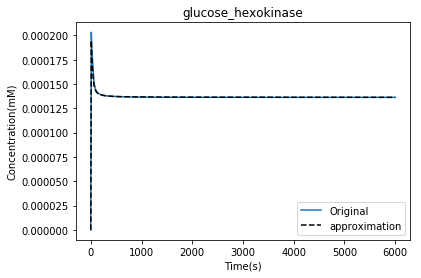

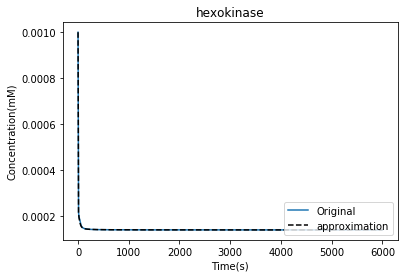

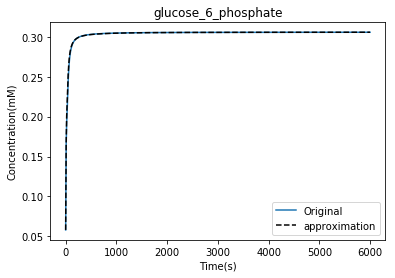

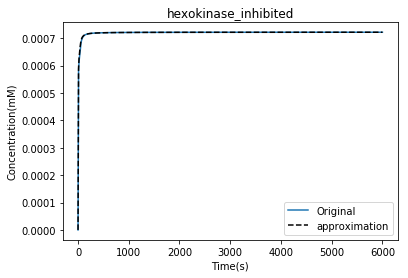

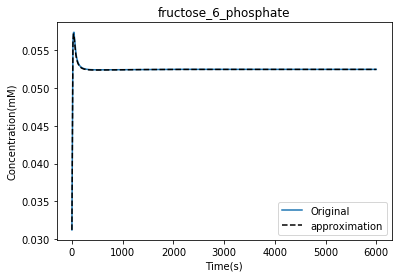

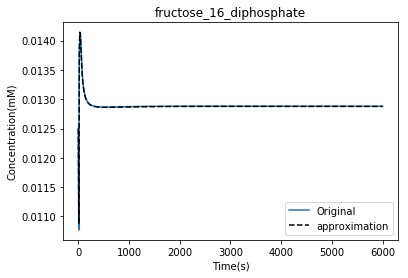

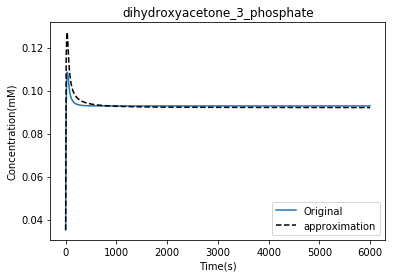

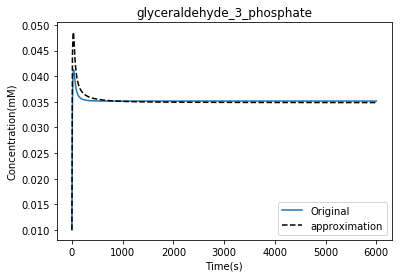

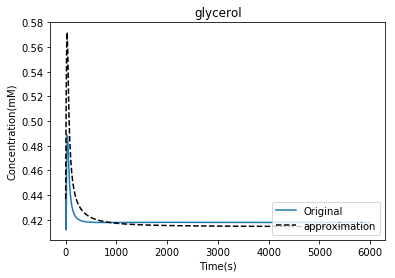

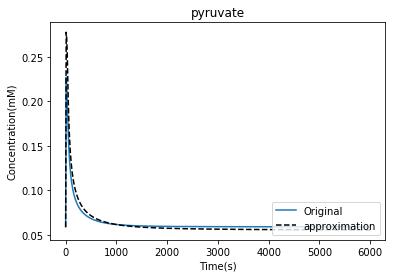

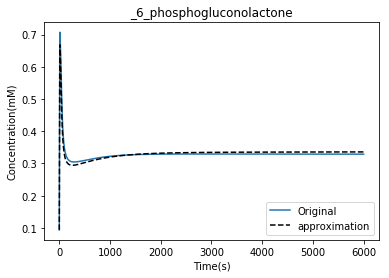

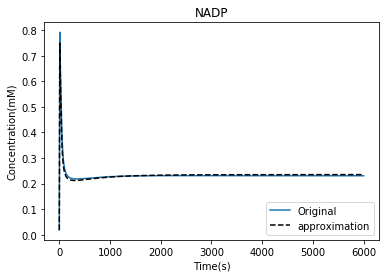

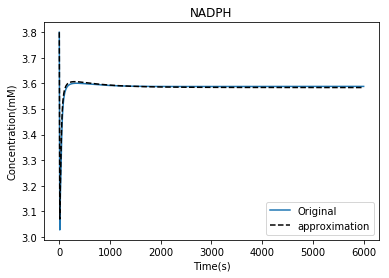

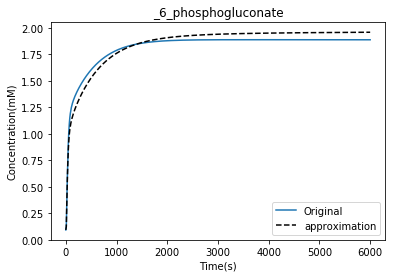

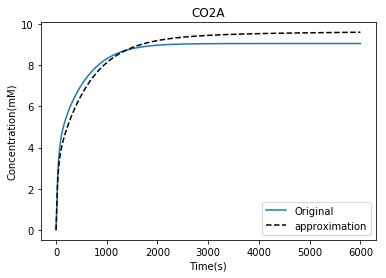

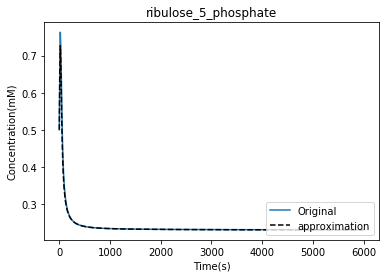

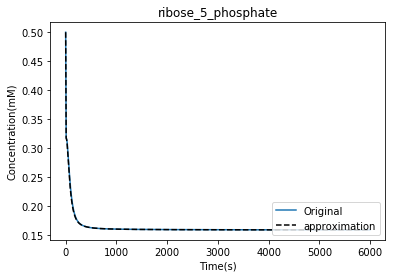

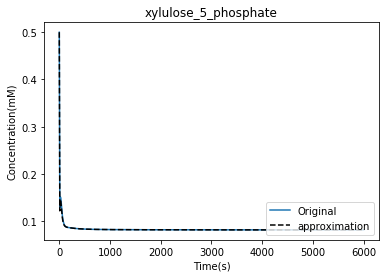

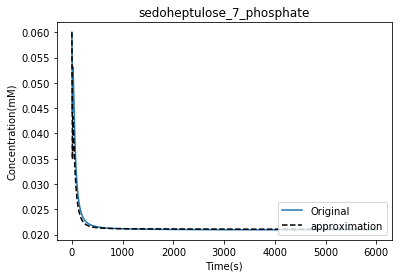

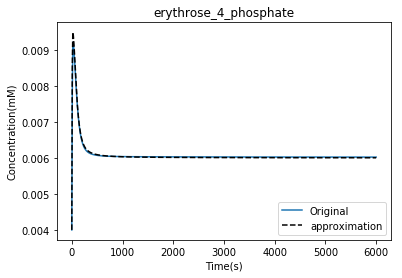

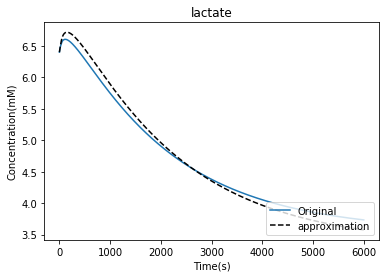

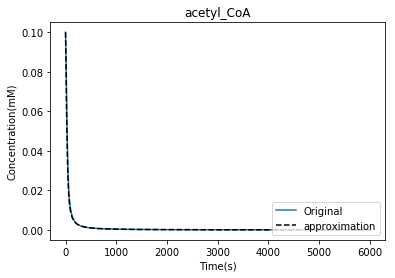

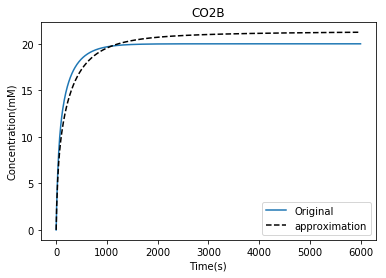

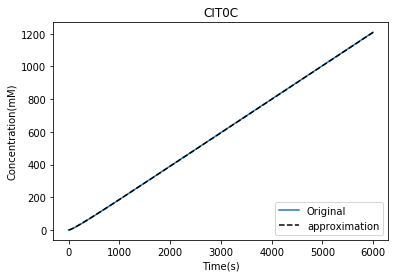

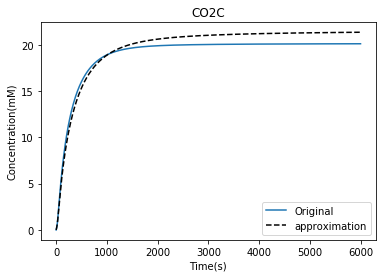

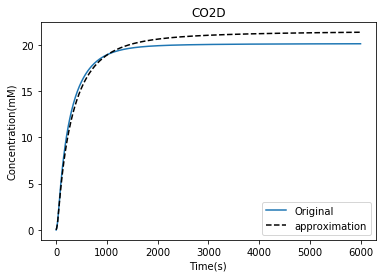

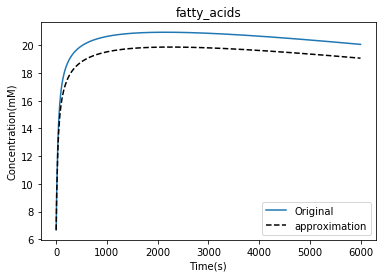

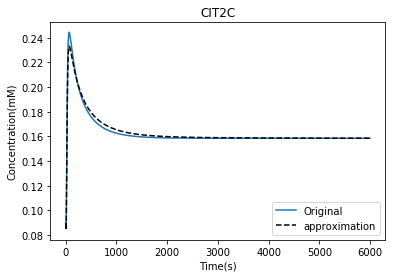

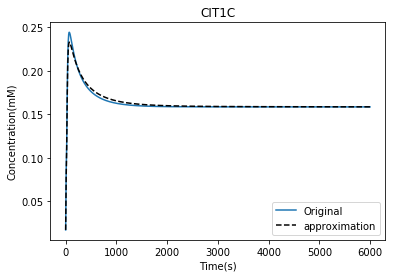

In [20]:
for stateVar,i in zip(BGmodel.state_vars,range(len(BGmodel.state_vars))):  
    if BGmodel.state_vars[stateVar][0].name in solutions:
        plt.figure()
        plt.title(BGmodel.state_vars[stateVar][0].name)
        plt.plot(solutions['Time'],solutions[BGmodel.state_vars[stateVar][0].name],label='Original')
        plt.plot(t,x[:,i],'--k',label='approximation')
        plt.legend(loc='lower right')
        plt.ylabel('Concentration(mM)')
        plt.xlabel('Time(s)')